In [50]:
#import
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

In [51]:
#defining necessary parameters

#phisical parameters
global k_pr, m, e, e0, k, n0, t0, L0, T0, E0, c, six, two, one, half, four, set_rel_err, eight, sixteen, mu, three, twelve, oneAhalf
oneAhalf = np.float64(1.5)
three = np.float64(3.)
sixteen = np.float64(16.)
set_rel_err= np.float64(1e-6)
eight = np.float64(8.)
one = np.float64(1.)
six = np.float64(6.)
two = np.float64(2.)
half = np.float64(0.5)
four = np.float64(4.)
twelve = np.float64(12.)

k_pr = 8.9875517873681764e9
m = np.zeros(6)
m[0] = 9.1093821545E-31
e = 1.60217648740E-19
m[1] = (1.66053878283E-27)*39.948
m[3] = m[1]-m[0]
e0 = 8.854187817e-12
k = 1.380650424E-23

m[2]=(1.66053878283E-27)*55.845
m[4]=m[2]-m[0]
m[5]=m[4]-m[0]

mu = np.zeros([6,6])

for i in range(6):
    for j in range(6):
    
        mu[i,j] = m[i]*m[j]/(m[i]+m[j])

#normalizing parameters
n0=1e23
L0=1e-4
v0=1000
T0=1
t0=L0/v0
j0=n0*v0*e
E0=T0/L0
c = np.zeros(6)
c[:]=np.sqrt(e*T0/m[:])/v0


In [52]:
#set of functions

def set_nonl_grid(lenght, xN, coef):
    
    #lenght - [m]
    # xN - number of cells
    xL=np.float64(0.)
    xR=xL+(lenght/L0)
    H=xR
    
    #uniformly distributed parameter
    ksi = np.zeros(xN+1)
    
    for i in range(np.int(xN)):
        
        ksi[i+1] = ksi[i] + one/xN
            
    tmpr=((coef+one)/(coef-one))**(one-ksi)
    #current x has 1001 points!!!! - the edges
    x=H*(coef+one-(coef-one)*tmpr)/(one+tmpr)
    
    #size of each cell
    dx=(x[1:xN+1]-x[0:xN])
    
    #now x - array of coordinates of cells
    x = np.zeros(xN)
    x[0] = xL+half*dx[0]
    
    for i in range(dx.size-1):
        
        x[i+1] = x[i] + half*(dx[i+1]+dx[i])
    
    #%линейная двухточечная аппроксимация нелинейной сетки
    w_r = dx[0:xN-1]/(dx[0:xN-1]+dx[1:xN])                        #    !линейная аппроксимация внутри области П= mass_r(1)*П2+mass_l(1)*П1; П1,П2-значения в ячейках П-между ячейками
    w_l = dx[1:xN]/(dx[0:xN-1]+dx[1:xN])

    we_l = np.zeros(2)
    we_r = np.zeros(2)
    we_r[0]=-(dx[xN-1]/(dx[xN-2]+dx[xN-1]))                             #  !линейная аппроксимация на правой границе области П= edge_r(1)*П1+edge_r(2)*П2; П1,П2-значения в ячейках П-на правая грань
    we_r[1]=((dx[xN-2]+two*dx[xN-1])/(dx[xN-2]+dx[xN-1])) 

    we_l[0] = (two*dx[0]+dx[1])/(dx[0]+dx[1])                       # !линейная аппроксимация на левой границе области П= edge_l(1)*П1+edge_l(2)*П2; П1,П2-значения в ячейках П-на левой грани
    we_l[1] = -dx[0]/(dx[0]+dx[1])

    
    return x, dx, w_r, w_l, we_r, we_l

def Ion_Rec_Ar_Fe(Te):
    
#     work in range 0.2 - 3 eV
    x = np.log(Te)

#     for t0 = 1e-7 and n =1e23 T0 = 1
#     Ar0
    p_Ar = np.zeros(7)
    p_Ar[0] = -np.float64(0.3951)
    p_Ar[1] = np.float64(0.3388)
    p_Ar[2] = -np.float64(0.03006)
    p_Ar[3] = np.float64(1.718)
    p_Ar[4] = -np.float64(5.701)
    p_Ar[5] = np.float64(12.49)
    p_Ar[6] = -np.float64(6.908)
    
    
#     1 % - relative error approximation
    
    I_Ar = np.exp(sum(np.array([p_Ar[i]*(x**(six-i)) for i in range(p_Ar.size)])))
    
    p_Ar[0] = -np.float64(0.3891)
    p_Ar[1] = np.float64(0.2566)
    p_Ar[2] = np.float64(0.9171)
    p_Ar[3] = -np.float64(0.6377)
    p_Ar[4] = np.float64(2.212)
    p_Ar[5] = -np.float64(4.865)
    p_Ar[6] = -np.float64(56.85)
    
    
    R_Ar = np.exp(sum(np.array([p_Ar[i]*x**(six-i) for i in range(p_Ar.size)])))
    
#     Fe0
    p_Fe = np.zeros(7)
    p_Fe[0] = -np.float64(0.01412)
    p_Fe[1] = np.float64(0.06936)
    p_Fe[2] = -np.float64(0.3241)
    p_Fe[3] = np.float64(1.315)
    p_Fe[4] = -np.float64(3.953)
    p_Fe[5] = np.float64(8.403)
    p_Fe[6] = -np.float64(1.898)
    
    
#     1 % - relative error approximation
    
    I_Fe =  np.exp(sum(np.array([p_Fe[i]*x**(six-i) for i in range(p_Ar.size)])))
    
    
    p_Fe[0] = np.float64(0.0131)
    p_Fe[1] = np.float64(0.08291)
    p_Fe[2] = np.float64(0.01917)
    p_Fe[3] = -np.float64(0.324 )
    p_Fe[4] = -np.float64(0.0791)
    p_Fe[5] = -np.float64(0.4089)
    p_Fe[6] = -np.float64(58.03)
    
    
    R_Fe = np.exp(sum(np.array([p_Fe[i]*x**(six-i) for i in range(p_Ar.size)])))
    
    
#     Fe1
    p_Fe[0] = -np.float64(0.02892)
    p_Fe[1] = np.float64(0.1421)
    p_Fe[2] = -np.float64(0.6638)  
    p_Fe[3] = np.float64(2.693)
    p_Fe[4] = -np.float64(8.098)
    p_Fe[5] = np.float64(16.69)
    p_Fe[6] = -np.float64(10.9)
    
    
#     1 % - relative error approximation
    
    I_Fe1 = np.exp(sum(np.array([p_Fe[i]*x**(six-i) for i in range(p_Ar.size)])))
    
    
    p_Fe[0] = -np.float64(0.007245)
    p_Fe[1] = -np.float64(0.00883)
    p_Fe[2] = np.float64(0.02286)
    p_Fe[3] = -np.float64(0.002405)
    p_Fe[4] = -np.float64(0.09593)
    p_Fe[5] = -np.float64(0.7813)
    p_Fe[6] = -np.float64(57.78)
    
    R_Fe1 = np.exp(sum(np.array([p_Fe[i]*x**(six-i) for i in range(p_Ar.size)])))

#     dimentionless output
    return I_Ar, R_Ar*n0, I_Fe, R_Fe*n0, I_Fe1, R_Fe1*n0

def Def_n(P,j,gamma,Th,Te):

    alpha1, beta1, alpha2, beta2, alpha3, beta3 = Ion_Rec_Ar_Fe(Te)

    S1=alpha1/beta1

    S2=alpha2/beta2

    S3=alpha3/beta3
    
    stat_sys = lambda x: P-x*Te-(Th/gamma)*(x/( (((one/gamma)-one)/((x/S1)+one))+(((x/S3)+np.float64(2)) / (one+(x/S3)+(x*x/(S2*S3)))) ))
    
    n_1_it = spo.fsolve(stat_sys, x0 = 0.5*P, xtol = 1e-7, )
    
    n_1 = n_1_it[-1]
    n_6=n_1/( (((one/gamma)-one)/((n_1/S1)+one))*(one+(n_1/S3)+(n_1*n_1/(S2*S3)))+((n_1/S3)+np.float64(2)) )
    
    n_5=n_1*n_6/S3          
    n_3=n_1*n_5/S2             
    n_4=n_1-n_5-two*n_6
    n_2=n_1*n_4/S1

    
    return n_1, n_2, n_3, n_4, n_5, n_6

In [53]:
#initialization of the grid and first approximation

global xN

xN = 1000
x, dx, w_r, w_l, we_r, we_l = set_nonl_grid(np.float64(1e-3), np.float64(1e3), np.float64(1.03))
# print x.size
# plt.plot(x)
# plt.show()

# %задание начальных безразмерных параметров для определения характеристик
# %невозмущенной плазмы
global P
P = np.float64(101325) #%Па
q = np.float64(6390)*np.float64(56)/(np.float64(8.31)*np.float64(3133)) #;%коэффиц в exp в ур клаузиус клайпер для Fe
Tb = np.float64(3133)/np.float64(11600)
P = P/(e*T0*n0)
    
j = np.float64(1e6)  #; %A/mm^(2)
j = j/j0

gamma = 0.5

T1 = np.float64(10000)#;%К
T1 = T1/np.float64(11640)#; %эВ
T1 = T1/T0;
    
Th=np.float64(2700)#;%К
Th=Th/np.float64(11640)#;%эВ
Th=Th/T0

n_in = np.zeros(6)

n_in[0], n_in[1], n_in[2], n_in[3], n_in[4], n_in[5] = Def_n(P,j,gamma,Th,T1)


# initial distribution of concentrations = initial approximation of solution

n = np.ones([6, xN])

for i in range(6):
    
    n[i,:] = np.ones(xN)*n_in[i]
    
temp = Th
Th = np.ones(xN)*temp
Tmep = T1
T1 = np.ones(xN)*temp

C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Equistant-adm\Anaconda2\lib\site-pac

In [54]:
def rad_Deb(n1, n4, n5, n6, Th, T1):

    return (((n4/Th)+(n5/Th)+(four*n6/Th)+(n1/T1))*(n0*e/(T0*e0)))**(-half)

def freq(Th, T1, rd):
    
    nu = np.zeros([6,6,xN])
    
    #12
    tmpre1=np.array([1.80361736371906,-0.56290476079401])

    g = (e*T1/m[0]) + (e*Th/m[1])
    g = one/g
    v = np.sqrt(eight/(np.pi*g))
    E = (half*(m[0]*m[1]/(m[0]+m[1]))*v*v)/e
    S = (tmpre1[0]*E+tmpre1[1])/np.float64(1e20)
    nu[0,1,:] = (four/three)*v*S
    nu[1,0,:] = nu[0,1,:]
    
#     13
    g=(e*T1/m[0])+(e*Th/m[2])
    v=np.sqrt(eight*g/np.pi)
    nu[0,2,:] = (four/three)*v*(np.float64(4.25)/np.float64(1e19))*np.sqrt(np.float64(13.6)/(np.float64(1.5)*Th))
    nu[2,0,:] = nu[0,2,:]
    
# 14
    
    g=(e*T1/m[0])+(e*Th/m[3])
    g=one/g
    L=((np.float64(12)*np.pi*e0)/(e*e))*((m[0]*m[3]/(m[0]+m[3]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)   
    nu[0,3,:] = (sixteen*np.sqrt(np.pi)/three)*((half*g)**np.float64(1.5))*(((e*e)/(four*np.pi*e0*(m[0]*m[3]/(m[0]+m[3]))))**two)*L
    nu[3,0,:] = nu[0,3,:]
    
# 15
    g = (e*T1/m[0]) + (e*Th/m[4])
    g = one/g
    L=((twelve*np.pi*e0)/(e*e))*((m[0]*m[4]/(m[0]+m[4]))/g)*rd
    L=np.log(L)+0*np.float64(1.6544)
    nu[0,4,:] =(sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((e*e)/(four*np.pi*e0*(m[0]*m[4]/(m[0]+m[4]))))**two)*L
    nu[4,0,:]=nu[0,4,:]
    
# 16
    g=(e*T1/m[0])+(e*Th/m[5])
    g=one/g
    L=((twelve*np.pi*e0)/(two*e*e))*((m[0]*m[5]/(m[0]+m[5]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)   
    nu[0,5,:] = (sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((two*e*e)/(four*np.pi*e0*(m[0]*m[5]/(m[0]+m[5]))))**two)*L
    nu[5,0,:] =nu[0,5,:] 

    # 23
    g=(e*Th/m[1])+(e*Th/m[2])
    v=np.sqrt(eight*g/np.pi)
    nu[1,2,:]=(four/three)*v*(np.float64(0.85)/np.float64(1e19))*two*np.pi
    nu[2,1,:]=nu[1,2,:]

# 24

    tmpre2=np.array([-0.1,0.6,1.15E-18,0.0543,0.015])
    g=(e*Th/m[3])+(e*Th/m[1])
    v=(np.sqrt(eight*g/np.pi))
    E=(half*(m[1]*m[3]/(m[3]+m[1]))*v*v)/e
    nu[1,3,:]=(four/three)*v*(tmpre2[2]*(E**tmpre2[0])*((one+(tmpre2[4]/E))**tmpre2[1])+
                       (np.float64(110.6)/np.float64(1e20))*(one+tmpre2[3]*np.log(one/E))**two)
    nu[3,1,:]=nu[1,3,:]


# 25
    g=(e*Th/m[1])+(e*Th/m[4])
    v=(np.sqrt(eight*g/np.pi))
    nu[1,4,:] = (four/three)*v*(np.float64(1.95)/np.float64(1e19))*two*np.pi
    nu[4,1,:] =nu[1,4,:] 

# 26
    g=(e*Th/m[1])+(e*Th/m[5])
    v=(np.sqrt(eight*g/np.pi))
    nu[1,5,:]=(four/three)*v*(half/np.float64(1e19))*two*np.pi
    nu[5,1,:]= nu[1,5,:]
        
# 34
    g=(e*Th/m[2])+(e*Th/m[3])
    v=(np.sqrt(eight*g/np.pi))
    nu[2,3,:]=(four/three)*v*(np.float64(1.95)/np.float64(1e19))*two*np.pi
    nu[3,2,:]=nu[2,3,:]
    
# 35
    g=(e*Th/m[2])+(e*Th/m[4])
    v=(np.sqrt(eight*g/np.pi))
    nu[2,4,:]=(four/three)*v*(np.float64(1.8)/np.float64(1e18))*(one-np.float64(0.11)*np.log(oneAhalf*Th))
    nu[4,2,:]=nu[2,4,:]
    
# 36
    g=(e*Th/m[2])+(e*Th/m[5])
    v=(np.sqrt(eight*g/np.pi))
    nu[2,5,:]=(four/three)*v*np.float64(0.85)*np.float64(1e-19)*two*np.pi
    nu[5,2,:]=nu[2,5,:]

# 45
    g=(e*Th/m[3])+(e*Th/m[4])
    g=one/g
    L=((twelve*np.pi*e0)/(e*e))*((m[3]*m[4]/(m[3]+m[4]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)   
    nu[3,4,:]=(sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((e*e)/(four*np.pi*e0*(m[3]*m[4]/(m[3]+m[4]))))**two)*L
    nu[4,3,:]=nu[3,4,:]

# 46
    g=(e*Th/m[3])+(e*Th/m[5])
    g=one/g
    L=((twelve*np.pi*e0)/(two*e*e))*((m[3]*m[5]/(m[3]+m[5]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)   
    nu[3,5,:]=(sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((two*e*e)/(four*np.pi*e0*(m[3]*m[5]/(m[3]+m[5]))))**two)*L
    nu[5,3,:]=nu[3,5,:]

# 56
    g=(e*Th/m[4])+(e*Th/m[5])
    g=one/g
    L=((twelve*np.pi*e0)/(two*e*e))*((m[4]*m[5]/(m[4]+m[5]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)
    nu[4,5,:]=(sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((two*e*e)/(four*np.pi*e0*(m[4]*m[5]/(m[4]+m[5]))))**two)*L
    nu[5,4,:]= nu[4,5,:]
    
    return nu

def args_A(nu, n):
    
    omega = np.zeros([6,6,xN])
    ksi = np.zeros([6,6,xN])
    
    for i in range(6):
        for j in range(6):
            if (i <> j):
                
                omega[i,j,:] = nu[i,j,:]*t0*n0*n[j,:]
                ksi[i,j,:] = omega[i,j,:]*(mu[i,j]/m[i])*(n[i,:]/n[j,:])
    
    for i in range(6):
        for j in range(6):
            
            ksi[i,i,:] = ksi[i,i,:] + ksi[i,j,:]*(n[j,:]/n[i,:])
    
    return ksi

def buid_feq_mat(B, IRc, n, Th, T1):
    
    #B==ksi
    A = np.zeros([4, 4, xN])
    
    A[0,0,:] = -B[2,2,:] - IRc[0, 0, :]*n[0, :]
    A[0,1,:] =  B[2,3,:] - B[2,1,:] + B[2,0,:]
    A[0,2,:] =  B[2,4,:] + B[2,0,:] + IRc[1, 1, :]*n[0, :]*n[0, :]
    A[0,3,:] =  B[2,5,:] + two*B[2,0,:]
    
    A[1,0,:] =  B[3,2,:] + (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*B[0,2,:]
    A[1,1,:] =  B[3,0,:] - (B[3,1,:] + IRc[0,1,:]*n[0,:]*n[0,:]) - B[4,4,:] - IRc[1,0,:]*n[0,:]*n[0,:] - (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*(B[0,1,:]-B[0,3,:]+ B[0,0,:])
    A[1,2,:] =  B[3,4,:] + B[3,0,:] + (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*(B[0,4,:]-B[0,0,:])
    A[1,3,:] =  B[3,5,:] + two*B[3,0,:] + (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*(B[0,5,:]-two*B[0,0,:])
    
    A[2,0,:] =  B[4,2,:] + IRc[0, 1, :]*n[0, :] + (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*B[0,2,:]
    A[2,1,:] =  B[4,3,:] - B[4,1,:] + B[4,0,:] - (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*(B[0,1,:]-B[0,3,:]+ B[0,0,:])
    A[2,2,:] =  B[4,0,:] - B[4,4,:] - IRc[0,2,:]*n[0,:] - IRc[1,1,:]*n[0,:]*n[0,:] + (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*(B[0,4,:]-B[0,0,:])
    A[2,3,:] =  B[4,5,:] + two*B[4,0,:] + IRc[1, 2, :]*n[0, :]*n[0, :] + (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*(B[0,5,:]-two*B[0,0,:])
    
    A[3,0,:] =  B[5,2,:] + two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*B[0,2,:]
    A[3,1,:] =  B[5,3,:] - B[5,1,:] + B[5,0,:] - two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*(B[0,1,:]-B[0,3,:]+ B[0,0,:])
    A[3,2,:] =  B[5,4,:] + B[5,0,:] + IRc[0,2,:]*n[0,:] + two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*(B[0,4,:]-B[0,0,:])
    A[3,3,:] =  two*B[5,0,:] - two*B[5,5,:] - IRc[1, 2, :]*n[0, :]*n[0, :] + two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*(B[0,5,:]-two*B[0,0,:])
    
    AD = np.zeros([4,4,xN])
    
    for i in range(A.shape[2]):
        
        A[:,:,i] = np.linalg.inv(A[:,:,i])
    
    D = np.zeros([4,4,xN])
    
    for i in range(4):
        
        D[i,i,:] = c[i+2]*c[i+2]*Th[:]
    
    D[1,1,:] = D[1,1,:] + (c[3]*c[3]*n[3,:]/n[1,:])*T1[:]
    D[1,2,:] = (c[3]*c[3]*n[3,:]/n[1,:])*T1[:]
    D[1,3,:] = two*(c[3]*c[3]*n[3,:]/n[1,:])*T1[:]
    
    D[2,1,:] = (c[4]*c[4]*n[4,:]/n[1,:])*T1[:]
    D[2,2,:] = D[2,2,:] + (c[4]*c[4]*n[4,:]/n[1,:])*T1[:]
    D[2,3,:] = two*(c[4]*c[4]*n[4,:]/n[1,:])*T1[:]
    
    D[3,1,:] = two*(c[5]*c[5]*n[5,:]/n[1,:])*T1[:]
    D[3,2,:] = two*(c[5]*c[5]*n[5,:]/n[1,:])*T1[:]
    D[3,3,:] = D[3,3,:] + four*(c[5]*c[5]*n[5,:]/n[1,:])*T1[:]
    
    for i in range(xN):
        
        AD[:,:,i] = np.dot(A[:,:,i], D[:,:,i])
    
    J = np.zeros([4, xN])
    
    J[0,:] = B[2,0,:]
    J[1,:] = B[3,0,:] - (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*B[0,0,:]
    J[2,:] = B[4,0,:] - (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*B[0,0,:]
    J[3,:] = B[5,0,:] - two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*B[0,0,:]
    
    J = J*j
    
    AJ = np.zeros([4,xN])
    
    for i in range(xN):
        
        AJ[:,i] = np.dot(A[:,:,i],J[:,i])
    
    return AD, AJ

In [99]:
def build_Wb(AD, AJ, IRc, n):
    
    Jac_f = np.zeros([4,4,xN])
    
    Jac_f [0,0,:] = -IRc[0,1,:]*n[0,:]
    Jac_f [2,0,:] = IRc[0,1,:]*n[0,:]
    
    Jac_f [0,1,:] = two*IRc[1,1,:]*n[4,:]*n[0,:] - IRc[0,1,:]*n[2,:]
    Jac_f [1,1,:] = IRc[0,0,:]*n[1,:] - IRc[1,0,:]*n[0,:]*n[0,:] - two*IRc[1,0,:]*n[0,:]*n[3,:]
    Jac_f [2,1,:] = IRc[0,1,:]*n[2,:] - IRc[0,2,:]*n[4,:] - two*IRc[1,1,:]*n[0,:]*n[4,:] + two*IRc[1,2,:]*n[0,:]*n[5,:] 
    Jac_f [3,1,:] = IRc[0,2,:]*n[4,:] - two*IRc[1,2,:]*n[0,:]*n[5,:] 
    
    Jac_f [0,2,:] = IRc[1,1,:]*n[0,:]*n[0,:] - IRc[0,1,:]*n[2,:] +two*IRc[1,1,:]*n[0,:]*n[4,:]
    Jac_f [1,2,:] = IRc[0,0,:]*n[1,:] - two*IRc[1,0,:]*n[0,:]*n[3,:]
    Jac_f [2,2,:] = IRc[0,1,:]*n[2,:] - IRc[1,1,:]*n[0,:]*n[0,:] - IRc[0,2,:]*n[4,:] - IRc[0,2,:]*n[0,:] - two*IRc[1,1,:]*n[0,:]*n[4,:] + two*IRc[1,2,:]*n[0,:]*n[5,:] 
    Jac_f [3,2,:] = IRc[0,2,:]*n[4,:] + IRc[0,2,:]*n[0,:] - two*IRc[1,2,:]*n[0,:]*n[5,:] 
    
    Jac_f [0,3,:] = - two*IRc[0,1,:]*n[2,:] +four*IRc[1,1,:]*n[0,:]*n[4,:]
    Jac_f [1,3,:] = two*IRc[0,0,:]*n[1,:] - four*IRc[1,0,:]*n[0,:]*n[3,:]
    Jac_f [2,3,:] = IRc[1,2,:]*n[0,:]*n[0,:] + two*IRc[0,1,:]*n[2,:] - two*IRc[0,2,:]*n[4,:] - four*IRc[1,1,:]*n[0,:]*n[4,:] + four*IRc[1,2,:]*n[0,:]*n[5,:] 
    Jac_f [3,3,:] = two*IRc[0,2,:]*n[4,:] - IRc[1,2,:]*n[0,:]*n[0,:] - four*IRc[1,2,:]*n[0,:]*n[5,:] 
    
    b = np.zeros([4,xN])
    
    for i in range(1,xN-1):

        b[:,i] = (b[:,i]*w_l[i] + b[:,i+1]*w_r[i] - (b[:,i-1]*w_l[i-1] + b[:,i]*w_r[i-1]))/dx[i]
        
    WA = np.zeros([4,4,xN])
    WB = np.zeros([4,4,xN])
    WC = np.zeros([4,4,xN])
    
    for i in range(1,xN-1):
        
#     AD[:,:,i]*we_l[i] + AD[:,:,i+1]*we_l[i] - S^{i-0.5}
        WA[:, :, i-1] = (AD[:,:,i-1]*w_l[i-1] + AD[:,:,i]*w_r[i-1])/(dx[i]*half*(dx[i-1] + dx[i]))
        WC[:, :, i+1] = (AD[:,:,i]*w_l[i] + AD[:,:,i+1]*w_l[i])/(dx[i+1]*half*(dx[i+1] + dx[i]))
        WB[:, :, i] =  -(WA[:, :, i-1] + WC[:, :, i+1])
    
    return WA, WB, WC, b, Jac_f 

In [100]:
max_rel_err = one
A = np.zeros([4, 4, xN])


# while (max_rel_err < set_re;_err):

    #dimention rd
rd = rad_Deb(n[0,:], n[3,:], n[4,:], n[5,:], Th, T1)
    
IRc = np.zeros([2, 3, xN])
    
for i in range(xN):
        #dimentionless
        IRc[0,0,i], IRc[1,0,i], IRc[0,1,i], IRc[1,1,i], IRc[0,2,i], IRc[1,2,i] = Ion_Rec_Ar_Fe(T1[i])
        
nu = np.zeros([6, 6, xN])
    #dimention nu
nu = freq(Th, T1, rd)
    
ksi = args_A(nu, n)
    
AD = np.zeros([4, 4, xN])
AJ = np.zeros([4, 4, xN])
AD, AJ = buid_feq_mat(ksi, IRc, n, Th, T1)

WA, WB, WC, b, Jac_f = build_Wb(AD, AJ, IRc, n)
    
#     max_rel_err = max(abs(dn/n))




In [111]:
print WB[:,:,1]

[[  4.25419106e+03   5.37369237e+02   1.38300244e+03   1.17785116e+03]
 [  4.11344824e-02   8.67744463e+00   1.16029524e-01   1.18618378e-01]
 [  1.26946186e+03   1.42725363e+03   3.68026629e+03   3.44668071e+03]
 [  7.28414649e-03  -3.16640334e-02  -8.28397404e-03  -1.13826229e+03]]


In [49]:
print w_l.size

999


In [46]:
dx[xN]

IndexError: index 1000 is out of bounds for axis 0 with size 1000

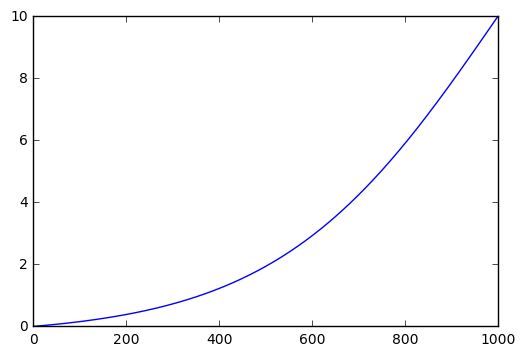

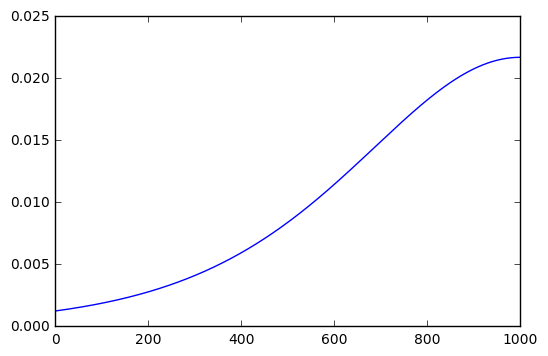

In [145]:
plt.plot(x)
plt.show()
plt.plot(dx)
plt.show()